In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [ ]:
# import custom networkx modifications & scraping functions
import networkx_util 

In [ ]:
# load saved network graph 
g3 = networkx_util.read_pajek_('/Users/brucehao/Google Drive/CUNY/git/DATA620/facebook_network.net')

In [ ]:
# create data frame to house user-item matrix
user_item_df = pd.DataFrame({'user': g3.nodes})
for node in g3.nodes:
    try:
        for key, value in g3.nodes[node].items():
            if 'Like: ' in key:
                user_item_df.loc[user_item_df['user'] == node, key] = value
    except:
        pass

    try:
        for yob in cleanse_yob_list(g3):
            if yob in g3.node[node]['Birthday']:
                user_item_df.loc[user_item_df['user'] == node, 'YOB: ' + yob] = 1
    except:
        pass

    try:
        for resid in cleanse_resid_list(g3):
            if resid in g3.node[node]['Live']:
                user_item_df.loc[user_item_df['user'] == node, 'Live: ' + resid] = 1
    except:
        pass

    try:
        for school in cleanse_school_list(g3):
            if school in g3.node[node]['Study']:
                user_item_df.loc[user_item_df['user'] == node, 'Study: ' + school] = 1
    except:
        pass

user_item_df = user_item_df.fillna(0)
user_item_df.to_csv('/Users/brucehao/Google Drive/CUNY/git/DATA620/user_item_df.csv',
                    index=False)

In [2]:
# import data - data has already been scraped and converted into a sparse matrix (in dataframe form)
data = pd.read_csv('/Users/brucehao/Google Drive/CUNY/git/DATA620/user_item_df.csv')
data.head()

,user,"Live: Seoul, Korea","Live: San Francisco, California",Study: Academy of Art University,YOB: 1994,Live: Nonthaburi,Study: Plernpattana,Study: Plearnpattana,Like: Movies,Like: Music,...,Study: Lancaster High School,Study: Gaithersburg High School,Study: Western Maryland/McDaniel College,Study: 銘傳大學 Ming Chuan University,Study: City College of San Francisco,Study: American River College,Study: Ulsan Art high School,Study: Amersham & Wycombe College,Study: Berkhamsted School,Study: Great Oak High School
0,seula.kim.1420,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,uni.chan.12,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,lu.sa.3382,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JingOuyang1116,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rayraykonpeitou,0.0,1.0,1.0,0.0,0.0,0.0,0.0,16,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# examine available attributes 
print(data.shape)

# aggregate number of birth years, places of residence and places of studies reported 
yob_y   = len(data.filter(regex=("YOB:*")).columns)
resid_y = len(data.filter(regex=("Live:*")).columns)
study_y = len(data.filter(regex=("Study:*")).columns)
like_y  = len(data.filter(regex=("Like:*")).columns)
y = [yob_y, resid_y, study_y, like_y]

# aggregate number of users that report each of the attributes 
yob_x   = data[data.filter(regex=("YOB:*")).sum(axis=1) > 0].shape[0]
resid_x = data[data.filter(regex=("Live:*")).sum(axis=1) > 0].shape[0]
study_x = data[data.filter(regex=("Study:*")).sum(axis=1) > 0].shape[0]
like_x  = data[data.filter(regex=("Like:*")).sum(axis=1) > 0].shape[0]
x = [yob_x, resid_x, study_x, like_x]

attr_summ = pd.DataFrame({'attr': ['YOB', 'resid', 'study', 'like'],
                          'total': [82, 82, 82, 82], 
                          'users': x,
                          'variety': y})

attr_summ
# sns.scatterplot(x=x, y=y, data=attr_summ)

(82, 144)


,attr,total,users,variety
0,YOB,82,38,18
1,resid,82,71,18
2,study,82,74,98
3,like,82,56,9


In [11]:
# normalize Liked items to be between 0-1 and sum to 1 
# this places more weight on the non-Liked items, e.g. place of study, residence, year of birth, etc. 
data.loc[:, data.columns.to_series().str.contains('Like: ')] = \
    data.loc[:, data.columns.to_series().str.contains('Like: ')].div(
        data.loc[:, data.columns.to_series().str.contains('Like: ')].sum(axis=1), 
    axis=0).fillna(0)

In [12]:
data.head()

,user,"Live: Seoul, Korea","Live: San Francisco, California",Study: Academy of Art University,YOB: 1994,Live: Nonthaburi,Study: Plernpattana,Study: Plearnpattana,Like: Movies,Like: Music,...,Study: Lancaster High School,Study: Gaithersburg High School,Study: Western Maryland/McDaniel College,Study: 銘傳大學 Ming Chuan University,Study: City College of San Francisco,Study: American River College,Study: Ulsan Art high School,Study: Amersham & Wycombe College,Study: Berkhamsted School,Study: Great Oak High School
0,seula.kim.1420,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,uni.chan.12,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,lu.sa.3382,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.083333,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JingOuyang1116,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rayraykonpeitou,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.207792,0.467532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# tranpose the dataframe and drop the items, keeping just the users  
data_users = pd.DataFrame.transpose(data)         # transpose so users are columns 
data_users.columns = data_users.iloc[0]           # make column names = to user names 
data_users = data_users[1:]                       # remove extra row 
data_users = data_users.reset_index()             # reset index to remove item names 
data_users = data_users.drop('index', 1)          # drop item names 
data_users.head()

user,seula.kim.1420,uni.chan.12,lu.sa.3382,JingOuyang1116,rayraykonpeitou,quangminh.trieu.3,ikkiiichi,samuel.kam.96,mabelthough,profile.php,...,juliedowning,eli.harris,dylan.vermeul,kevin.wueste,nihao.eric,jeff.otoole.98,alex.woo.568,daniel.macaluso.50,enigmatic.micks,ginger.pk
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,0,...,0,1,1,1,1,0,1,0,1,1
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# define a similarity function using cosign similarity 
def calculate_similarity(df):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(df.astype(float).values)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= df.columns, columns= df.columns)
    return sim

In [15]:
# using the similarity function, produce a user-user matrix 
data_matrix = calculate_similarity(data_users)
data_matrix.head()

user,seula.kim.1420,uni.chan.12,lu.sa.3382,JingOuyang1116,rayraykonpeitou,quangminh.trieu.3,ikkiiichi,samuel.kam.96,mabelthough,profile.php,...,juliedowning,eli.harris,dylan.vermeul,kevin.wueste,nihao.eric,jeff.otoole.98,alex.woo.568,daniel.macaluso.50,enigmatic.micks,ginger.pk
user,,,,,,,,,,,,,,,,,,,,,
seula.kim.1420,1.000000,0.258199,0.269272,0.666667,0.634600,0.577350,0.252144,0.761639,0.666667,0.0,...,0.250882,0.550019,0.644637,0.550598,0.502733,0.275968,0.601929,0.281553,0.550485,0.735238
uni.chan.12,0.258199,1.000000,0.208577,0.258199,0.245779,0.447214,0.195310,0.294982,0.258199,0.0,...,0.000000,0.213021,0.249667,0.213246,0.194708,0.000000,0.233126,0.000000,0.426404,0.284757
lu.sa.3382,0.269272,0.208577,1.000000,0.269272,0.300705,0.233197,0.236937,0.335876,0.269272,0.0,...,0.065143,0.327065,0.304545,0.256893,0.219979,0.029920,0.266700,0.272932,0.257845,0.336792
JingOuyang1116,0.666667,0.258199,0.269272,1.000000,0.634600,0.577350,0.252144,0.761639,0.666667,0.0,...,0.250882,0.550019,0.644637,0.550598,0.502733,0.275968,0.601929,0.281553,0.550485,0.735238
rayraykonpeitou,0.634600,0.245779,0.300705,0.634600,1.000000,0.549580,0.303297,0.811580,0.634600,0.0,...,0.296413,0.577959,0.685993,0.610573,0.534042,0.350678,0.635550,0.327104,0.615019,0.827750


In [16]:
# print out the top 10 most similar users to our first user 
print(data_matrix.loc['seula.kim.1420'].nlargest(11))

user
seula.kim.1420         1.000000
samuel.kam.96          0.761639
seonghyodamiane.cho    0.742296
ginger.pk              0.735238
nico.bee.509           0.716615
JingOuyang1116         0.666667
mabelthough            0.666667
jbowling1              0.666667
isabella.kung.18       0.666667
dylan.vermeul          0.644637
rayraykonpeitou        0.634600
Name: seula.kim.1420, dtype: float64


In [17]:
# calculate predicted scores for Liked items based on dot product of user similarity and user-item scores 
categories = data.loc[:, data.columns.to_series().str.contains('Like: ')].columns
scores = data_matrix.dot(
    data.loc[:, data.columns.to_series().str.contains('Like: ')].astype(float).values)
output_df = pd.DataFrame(scores)
output_df.columns = categories
output_df.head()

,Like: Movies,Like: Music,Like: Books,Like: TV Shows,Like: Sports Teams,Like: Apps and Games,Like: Athletes,Like: Restaurants,Like: People
user,,,,,,,,,
seula.kim.1420,6.161584,9.808039,2.175187,3.492303,0.184991,1.778376,0.469863,0.530594,0.070286
uni.chan.12,2.650614,4.233775,0.984794,1.424002,0.077590,0.775556,0.142407,0.214070,0.027222
lu.sa.3382,3.147343,5.146681,1.983260,1.758199,0.120049,0.989071,0.219058,0.256632,0.045468
JingOuyang1116,5.966542,9.669805,2.171400,3.467686,0.184991,1.770801,0.467970,0.530594,0.070286
rayraykonpeitou,6.665305,11.363438,2.451143,3.900689,0.301461,1.960371,0.542032,0.577078,0.090195


In [22]:
# isolate just the users that did not Like any items (as the rest already provided their scores)
users_to_pred_df = data.loc[data.loc[:, data.columns.to_series().str.contains('Like: ')].sum(axis=1) == 0, 'user']
users_to_pred_df.head()

0       seula.kim.1420
1          uni.chan.12
3       JingOuyang1116
5    quangminh.trieu.3
8          mabelthough
Name: user, dtype: object

In [23]:
# isolate predicted scored for Liked items for just users for which we want to predict 
output_df.loc[output_df.index.isin(users_to_pred), ]

,Like: Movies,Like: Music,Like: Books,Like: TV Shows,Like: Sports Teams,Like: Apps and Games,Like: Athletes,Like: Restaurants,Like: People
user,,,,,,,,,
seula.kim.1420,6.161584,9.808039,2.175187,3.492303,0.184991,1.778376,0.469863,0.530594,0.070286
uni.chan.12,2.650614,4.233775,0.984794,1.424002,0.077590,0.775556,0.142407,0.214070,0.027222
JingOuyang1116,5.966542,9.669805,2.171400,3.467686,0.184991,1.770801,0.467970,0.530594,0.070286
quangminh.trieu.3,5.349672,8.707403,1.939907,3.080492,0.160207,1.588378,0.414039,0.468273,0.060870
mabelthough,5.966542,9.669805,2.171400,3.467686,0.184991,1.770801,0.467970,0.530594,0.070286
profile.php,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Brie.milkv,5.327613,8.726345,1.952230,3.108939,0.198383,1.761080,0.413675,0.472408,0.060870
jcporras,5.167177,8.374297,1.880487,3.003104,0.160207,1.533559,0.405274,0.459508,0.060870
elevenshih,4.526857,7.215839,1.609070,2.543187,0.130808,1.340754,0.374260,0.442137,0.051272


In [24]:
# one way to test the accuracy of these predictions is comparing the predicted values for those 
# users that actually provided some scores 
users_to_test = output_df.loc[~output_df.index.isin(users_to_pred_df), ]
users_to_test.head()

,Like: Movies,Like: Music,Like: Books,Like: TV Shows,Like: Sports Teams,Like: Apps and Games,Like: Athletes,Like: Restaurants,Like: People
user,,,,,,,,,
lu.sa.3382,3.147343,5.146681,1.983260,1.758199,0.120049,0.989071,0.219058,0.256632,0.045468
rayraykonpeitou,6.665305,11.363438,2.451143,3.900689,0.301461,1.960371,0.542032,0.577078,0.090195
ikkiiichi,3.632145,5.897815,1.374057,1.919686,0.149736,1.024606,0.257430,0.362097,0.044350
samuel.kam.96,7.593067,12.774443,2.837189,4.542116,0.306861,2.358590,0.624778,0.672593,0.098508
leonardoromano89,2.253525,6.300383,0.826888,1.374310,0.438799,0.931013,0.286798,0.189001,0.063625


In [25]:
# normalize Liked items to be between 0-1 and sum to 1 in order to compare against actual scores 
in_sample_pred = users_to_test.div(users_to_test.sum(axis=1), axis=0).fillna(0)
in_sample_pred.head()

,Like: Movies,Like: Music,Like: Books,Like: TV Shows,Like: Sports Teams,Like: Apps and Games,Like: Athletes,Like: Restaurants,Like: People
user,,,,,,,,,
lu.sa.3382,0.230309,0.376611,0.145126,0.128657,0.008785,0.072376,0.016030,0.018779,0.003327
rayraykonpeitou,0.239314,0.407998,0.088007,0.140052,0.010824,0.070386,0.019461,0.020720,0.003238
ikkiiichi,0.247726,0.402254,0.093716,0.130930,0.010213,0.069882,0.017558,0.024696,0.003025
samuel.kam.96,0.238715,0.401609,0.089197,0.142797,0.009647,0.074151,0.019642,0.021145,0.003097
leonardoromano89,0.177943,0.497490,0.065293,0.108518,0.034648,0.073515,0.022646,0.014924,0.005024


In [26]:
# produce the same dataframe using actual scores 
data_reindex = data.set_index('user')
in_sample_actual = data_reindex.loc[~data_reindex.index.isin(users_to_pred_df), 
                                    data_reindex.columns.to_series().str.contains('Like: ')]
in_sample_actual.head()

,Like: Movies,Like: Music,Like: Books,Like: TV Shows,Like: Sports Teams,Like: Apps and Games,Like: Athletes,Like: Restaurants,Like: People
user,,,,,,,,,
lu.sa.3382,0.083333,0.166667,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
rayraykonpeitou,0.207792,0.467532,0.103896,0.194805,0.012987,0.012987,0.000000,0.000000,0.0
ikkiiichi,0.287671,0.342466,0.109589,0.164384,0.000000,0.027397,0.013699,0.054795,0.0
samuel.kam.96,0.067797,0.288136,0.050847,0.423729,0.000000,0.169492,0.000000,0.000000,0.0
leonardoromano89,0.048387,0.661290,0.000000,0.016129,0.016129,0.209677,0.048387,0.000000,0.0


In [27]:
# take the difference between the predicted and actual scores
in_sample_std = in_sample_pred - in_sample_actual
in_sample_std.head()

,Like: Movies,Like: Music,Like: Books,Like: TV Shows,Like: Sports Teams,Like: Apps and Games,Like: Athletes,Like: Restaurants,Like: People
user,,,,,,,,,
lu.sa.3382,0.146975,0.209945,-0.604874,0.128657,0.008785,0.072376,0.016030,0.018779,0.003327
rayraykonpeitou,0.031522,-0.059535,-0.015889,-0.054753,-0.002163,0.057399,0.019461,0.020720,0.003238
ikkiiichi,-0.039945,0.059788,-0.015873,-0.033454,0.010213,0.042485,0.003859,-0.030098,0.003025
samuel.kam.96,0.170918,0.113474,0.038349,-0.280932,0.009647,-0.095341,0.019642,0.021145,0.003097
leonardoromano89,0.129555,-0.163800,0.065293,0.092389,0.018519,-0.136163,-0.025741,0.014924,0.005024


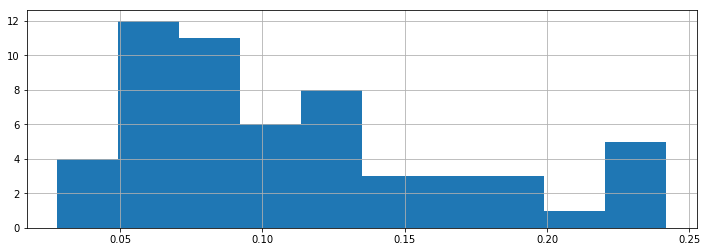

In [28]:
# calculate the standard deviation for each user 
# based on the histogram below, the predictions don't seem that far off 
# of course we'd need a baseline to compare these against but we would expect 
# that with more categories and scores these differences should smooth out 
plt.figure(3,figsize=(12,4)) 
in_sample_std.std(axis=1).hist()
plt.show()

In [45]:
# calculate correlation between actual and predicted preference ratings 
for col in in_sample_pred.columns: 
    print('%s: %f' % (col, in_sample_pred[col].corr(in_sample_actual[col])))

Like: Movies: 0.622846
Like: Music: 0.624148
Like: Books: 0.645781
Like: TV Shows: 0.615231
Like: Sports Teams: 0.830028
Like: Apps and Games: 0.607893
Like: Athletes: 0.562536
Like: Restaurants: 0.507973
Like: People: 0.939708
